# <font color='darkorange'> C02 - Baseline

# 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import re
import warnings
import inflection
import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
from pandas_profiling      import ProfileReport

import pipeline_class
from src                   import Starts

import umap
from plotly                import express as px 
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer 

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline      import Pipeline
from sklearn.cluster       import KMeans
from sklearn               import metrics
from sklearn.base          import BaseEstimator, TransformerMixin

/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_16737/194255285.py:8: DeprecationWarning: `import pandas_profiling` is goi

## 0.1. Helper Functions

In [3]:
starts = Starts()
starts.jupyter_settings()

## 0.2. Load Data

In [4]:
# Load Data
data_raw = pd.read_csv("data/raw/Ecommerce.csv", encoding='unicode_escape')

# Drop "Unnamed: 8" column
data_raw = data_raw.drop(columns = "Unnamed: 8")

| Column Name | Description                                            |
|-------------|--------------------------------------------------------|
| InvoiceNo   | Invoice number, a unique identifier for each transaction |
| StockCode   | Product code, a unique identifier for each product       |
| Description | Product description                                     |
| Quantity    | Quantity of products purchased in each transaction      |
| InvoiceDate | Date and time of each transaction                        |
| UnitPrice   | Unit price of each product                              |
| CustomerID  | Customer ID, a unique identifier for each customer       |
| Country     | Country of the customer                                 |


# 1.0. Data Description

In [5]:
df1 = data_raw.copy()
df1.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1. Rename Columns

In [6]:
# Class responsible for renaming columns. 
# It is inside utils directory
class RenameDataframeColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)
        
        return X
    
    def rename_columns(self, dataframe):
        # Copy DataFrame
        df = dataframe.copy()
        
        # Columns Names
        cols_old = list(df.columns)

        # Function to convert columns names to snake_case pattern
        snakecase = lambda x: inflection.underscore(x)

        # New columns names
        cols_new = list(map(snakecase, cols_old))

        # Apply new columns names to DataFrame
        df.columns = cols_new
        
        return df

In [7]:
# Create Pipeline to rename DataFrame
rename_pipe = Pipeline([
    ('rename', pipeline_class.RenameDataframeColumns())])

rename_pipe

Pipeline(steps=[('rename', RenameDataframeColumns())])

In [8]:

# Use Pipeline to rename DataFrame Columns
df1 = rename_pipe.fit_transform(df1)
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39      17850.0  United Kingdom

## 1.2. Data Dimensions

In [9]:
starts.data_dimensions(df1)

Number of rows: 541909
Number of cols: 8


## 1.3. Data Checks ( Types and NA )

In [10]:
starts.type_na(df1)

Type  number na percent na
invoice_no     object          0      0.0 %
stock_code     object          0      0.0 %
description    object       1454     0.27 %
quantity        int64          0      0.0 %
invoice_date   object          0      0.0 %
unit_price    float64          0      0.0 %
customer_id   float64     135080    24.93 %
country        object          0      0.0 %

In [11]:
# Convert date for datetime
df1.invoice_date = pd.to_datetime( df1.invoice_date, format='%d-%b-%y')

# 2.0. Exploratory Data Analysis - Invoices

In [12]:
df2 = df1.copy()

## 2.1. First view

### 2.1.1. Descriptive Statistics

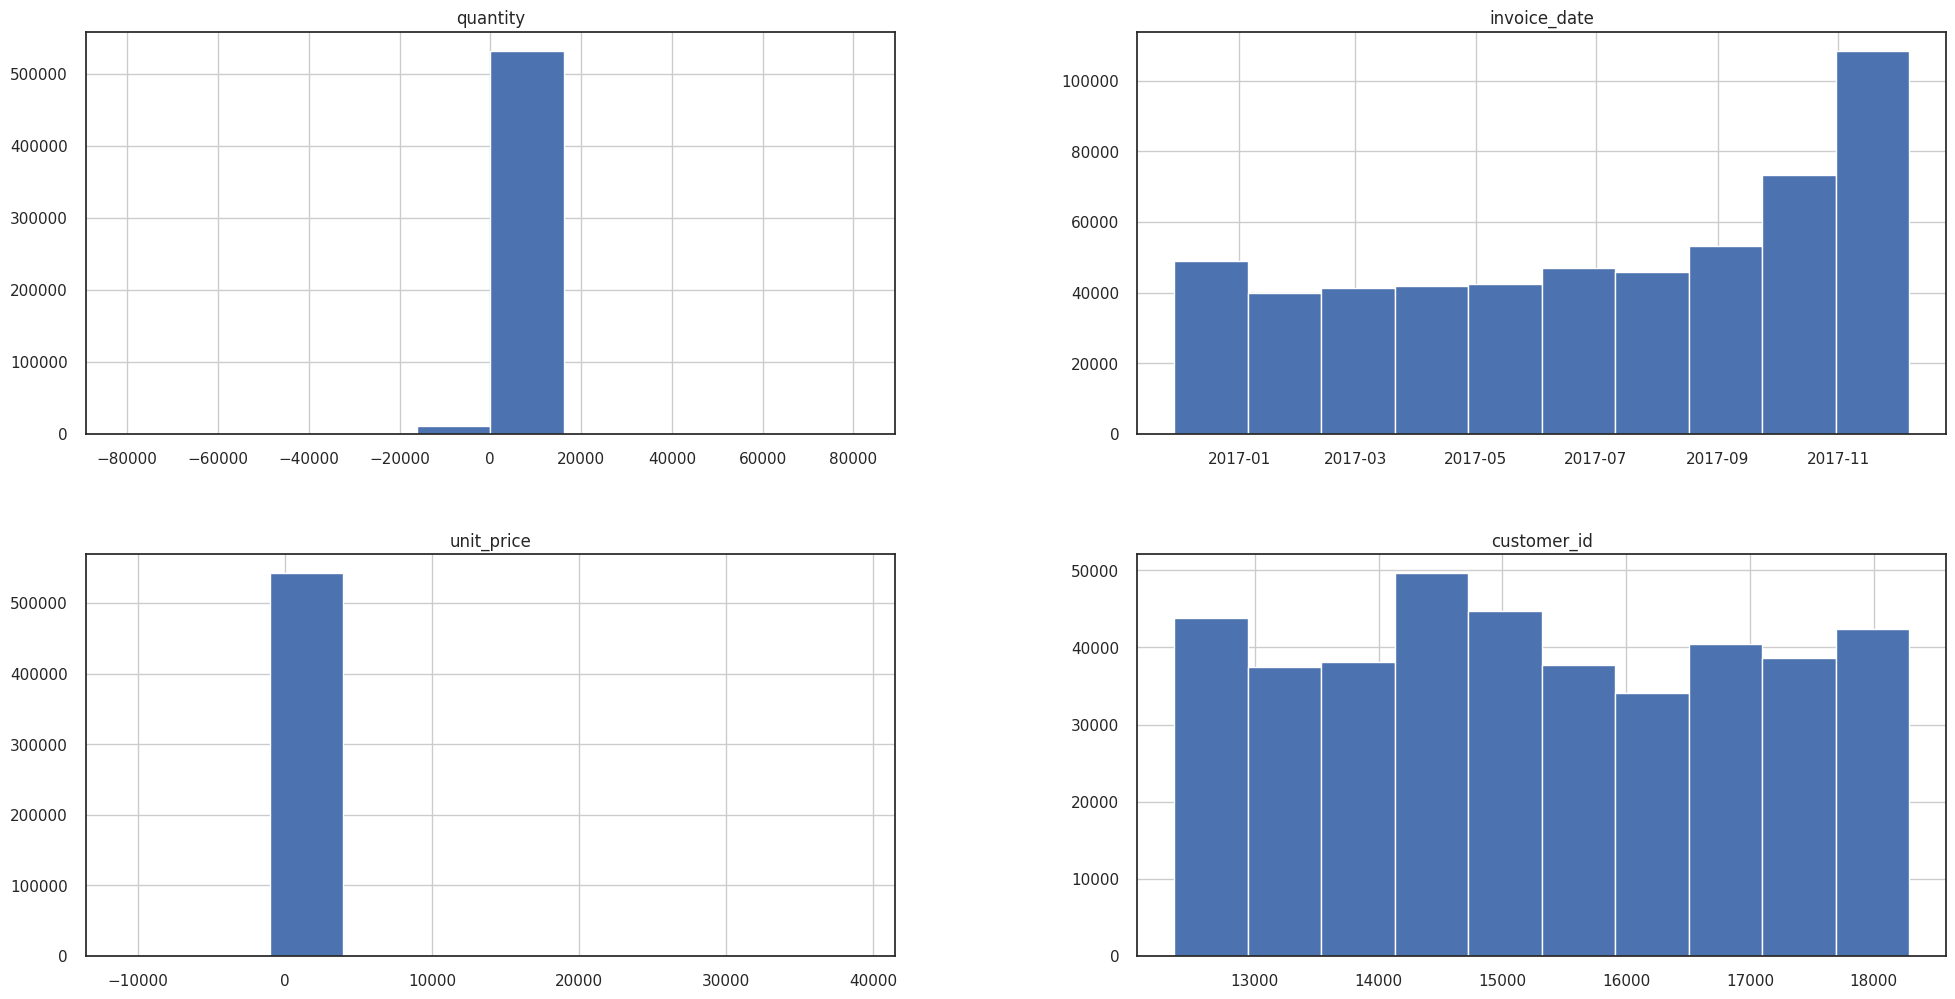

In [13]:
df2.hist();

In [14]:
starts.statistics_info(df2)

Non-Null      range       min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       541909  161990.00 -80995.00      1.00      3.00     10.00  80995.0      9.552250   218.081158   -0.264076  119769.160031
unit_price     541909   50032.06 -11062.06      1.25      2.08      4.13  38970.0      4.611114    96.759853  186.506972   59005.719097
customer_id    406829    5941.00  12346.00  13953.00  15152.00  16791.00  18287.0  15287.690570  1713.600303    0.029835      -1.179982

There are some numbers that call attention. In unit_price and quantity are negative numbers.

### 2.2.2. Categorical

In [15]:
print('Number of uniques: ')
for col in df2.select_dtypes(include='object'):
    print(f'{col}: {df2[col].nunique()}')

Number of uniques: 
invoice_no: 25900
stock_code: 4070
description: 4223
country: 38


The difference between stock_code numbers and descriptions draws attention.

## 2.2. Univariate Analysis

### 2.2.1. Invoice_no

In [16]:
returned_invoices = df2.invoice_no.str.contains(pat='[a-zA-Z]', regex=True)
df2.query('@returned_invoices').head()

invoice_no stock_code                       description  quantity invoice_date  unit_price  customer_id         country
141    C536379          D                          Discount        -1   2016-11-29       27.50      14527.0  United Kingdom
154    C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   2016-11-29        4.65      15311.0  United Kingdom
235    C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   2016-11-29        1.65      17548.0  United Kingdom
236    C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   2016-11-29        0.29      17548.0  United Kingdom
237    C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   2016-11-29        0.29      17548.0  United Kingdom

Invoices with letters means it is a return transaction as indicated by the negative values ​​in the column quantity.

In [17]:
# Check Invoices numbers without C
invoice_without_c = df2.invoice_no.isin(df2[returned_invoices].invoice_no.str[1:])
df2.query('@invoice_without_c')

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

There are no invoices with the same number of canceled invoices

In [18]:
returned_customers = df2[returned_invoices]
aux = df2[~returned_invoices]
returned_customers[~returned_customers.customer_id.isin(aux.customer_id)].customer_id.unique()[:10]

array([17547., 13958., 16995., 14213., 14679., 16138., 12870., 16252.,
       16579., 17307.])

In [19]:
df2.query('customer_id == 17547.0')

invoice_no stock_code           description  quantity invoice_date  unit_price  customer_id         country
4306    C536760      22175     PINK OWL SOFT TOY        -1   2016-11-30        2.95      17547.0  United Kingdom
4307    C536760      22273  FELTCRAFT DOLL MOLLY        -3   2016-11-30        2.95      17547.0  United Kingdom

And there are some customers with only canceled invoices, which means that canceled invoices are unique and not connected to other invoices.


With this information, I decided to divide the canceled invoices from the other invoices.


### 2.2.2. Stock_Code

In [20]:
df2.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39      17850.0  United Kingdom

Since most of the stock code starts with numbers, I will check if there is a stock code with only letters

In [21]:
df2[df2.stock_code.str.contains(pat='^[a-zA-Z]+$', regex=True)].stock_code.unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [22]:
stock_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2.query('stock_code == @stock_code').head()

invoice_no stock_code     description  quantity invoice_date  unit_price  customer_id         country
45       536370       POST         POSTAGE         3   2016-11-29       18.00      12583.0          France
141     C536379          D        Discount        -1   2016-11-29       27.50      14527.0  United Kingdom
386      536403       POST         POSTAGE         1   2016-11-29       15.00      12791.0     Netherlands
1123     536527       POST         POSTAGE         1   2016-11-29       18.00      12662.0         Germany
1814     536544        DOT  DOTCOM POSTAGE         1   2016-11-29      569.77          NaN  United Kingdom

As there is no information about these specific transitions, these invoices will be discarded in the next step.

### 2.2.3. quantity	

In [23]:
df2_clean = df2[~returned_invoices]
df2_clean = df2_clean.query('stock_code not in @stock_code')
df2_clean.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39      17850.0  United Kingdom

In [24]:
starts.statistics_info(df2_clean)

Non-Null    range      min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       530419  90595.0  -9600.0      1.00      3.00     10.00  80995.0     10.253177   159.868538  433.651234  211815.514184
unit_price     530419    649.5      0.0      1.25      2.08      4.13    649.5      3.263716     4.444391   24.866056    2210.717112
customer_id    396515   5941.0  12346.0  13975.00  15159.00  16801.00  18287.0  15301.349964  1709.783608    0.024004      -1.178771

In [25]:
df2_clean.query('quantity <= 0').sort_values('quantity')

invoice_no stock_code                   description  quantity invoice_date  unit_price  customer_id         country
225530     556691      23005  printing smudges/thrown away     -9600   2017-06-12         0.0          NaN  United Kingdom
225529     556690      23005  printing smudges/thrown away     -9600   2017-06-12         0.0          NaN  United Kingdom
225528     556687      23003  Printing smudges/thrown away     -9058   2017-06-12         0.0          NaN  United Kingdom
115818     546152     72140F                    throw away     -5368   2017-03-07         0.0          NaN  United Kingdom
431381     573596     79323W        Unsaleable, destroyed.     -4830   2017-10-29         0.0          NaN  United Kingdom
...           ...        ...                           ...       ...          ...         ...          ...             ...
75242      542566     84964B                           NaN        -1   2017-01-26         0.0          NaN  United Kingdom
156618     550153     85167B                       DAMAGED        -1   2017-04-12         0.0          NaN  United Kingdom
74284      542415     84967B                           NaN        -1   2017-01-25         0.0          NaN  United Kingdom
51763      540679      21667                           NaN        -1   2017-01-08         0.0          NaN  United Kingdom
75229      542553      21805                           NaN        -1   2017-01-26         0.0          NaN  United Kingdom

[1336 rows x 8 columns]

After checking the negative quantities, I discovered that they represent notes to write off products.

In [26]:
df2_clean = df2_clean.query('quantity > 0')

### 2.2.4. Invoice_date

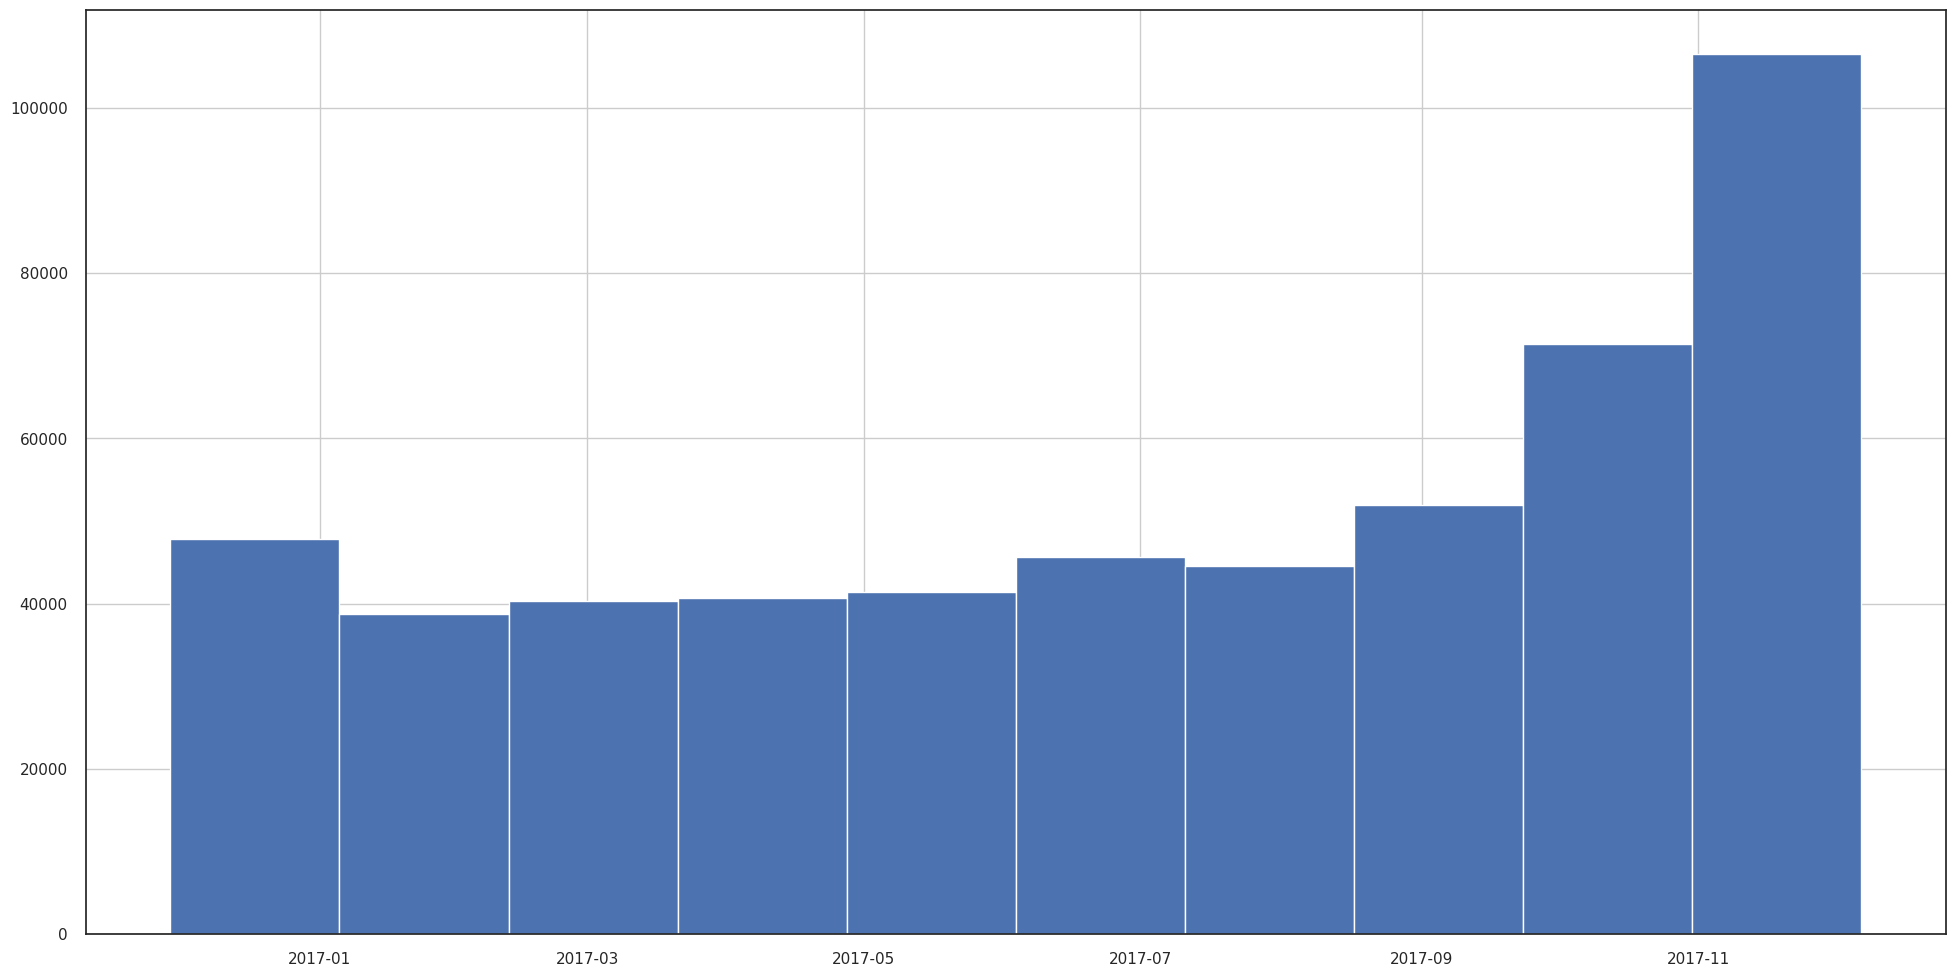

In [27]:
df2_clean.invoice_date.hist();

In [28]:
print(f'First day: {df2_clean.invoice_date.min()}')
print(f'Last day:  {df2_clean.invoice_date.max()}')

First day: 2016-11-29 00:00:00
Last day:  2017-12-07 00:00:00


### 2.2.5. Unit_price

In [29]:
starts.statistics_info(df2_clean)

Non-Null    range      min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       529083  80994.0      1.0      1.00      3.00     11.00  80995.0     10.670229   157.099233  459.672135  227638.300347
unit_price     529083    649.5      0.0      1.25      2.08      4.13    649.5      3.271957     4.446968   24.880972    2210.982127
customer_id    396515   5941.0  12346.0  13975.00  15159.00  16801.00  18287.0  15301.349964  1709.783608    0.024004      -1.178771

In [30]:
# Check unitprice = 0
df2_clean.query('unit_price == 0').head()

invoice_no stock_code description  quantity invoice_date  unit_price  customer_id         country
622      536414      22139         NaN        56   2016-11-29         0.0          NaN  United Kingdom
1970     536545      21134         NaN         1   2016-11-29         0.0          NaN  United Kingdom
1971     536546      22145         NaN         1   2016-11-29         0.0          NaN  United Kingdom
1972     536547      37509         NaN         1   2016-11-29         0.0          NaN  United Kingdom
1987     536549     85226A         NaN         1   2016-11-29         0.0          NaN  United Kingdom

The invoices with 0 unit price don't have usefull information

After checking the descriptions with missing values, I discovered that the purchases do not contain any useful information.

In [31]:
df2_clean = df2_clean.query('unit_price > 0.01')

### 2.2.6. Description

In [32]:
starts.type_na(df2_clean)

Type  number na percent na
invoice_no            object          0      0.0 %
stock_code            object          0      0.0 %
description           object          0      0.0 %
quantity               int64          0      0.0 %
invoice_date  datetime64[ns]          0      0.0 %
unit_price           float64          0      0.0 %
customer_id          float64     131436     24.9 %
country               object          0      0.0 %

In [33]:
df2_clean.description = df2_clean.description.str.strip().str.upper()

In [34]:
# Check stock code and descriptions
print( f'stock_code: {df2_clean.stock_code.nunique()}')
print( f'description: {df2_clean.description.nunique()}')

stock_code: 3912
description: 4006


After performing all the necessary cleaning, the difference between these columns still remains in the dataset.

In [35]:
# check stock code with more than one description
aux = df2_clean.groupby('stock_code')[['description']].nunique().reset_index().sort_values('description', ascending=False)
aux[aux.description > 1]

stock_code  description
2049      23196            4
2089      23236            4
2228      23396            3
104      17107D            3
2364      23535            3
...         ...          ...
3550     90014C            2
2002      23148            2
46       16156L            2
123       20622            2
175       20725            2

[217 rows x 2 columns]

In [36]:
df2_clean.query('stock_code == "23396"').description.unique()

array(['BUTTERFLY CUSHION COVER', 'LA JARDIN BOTANIQUE CUSHION COVER',
       'LE JARDIN BOTANIQUE CUSHION COVER'], dtype=object)

After checking the stock codes that had more than one description, I found that the additional descriptions were only minor corrections to the name.

### 2.2.7. customer_id	

In [37]:
starts.type_na(df2_clean)

Type  number na percent na
invoice_no            object          0      0.0 %
stock_code            object          0      0.0 %
description           object          0      0.0 %
quantity               int64          0      0.0 %
invoice_date  datetime64[ns]          0      0.0 %
unit_price           float64          0      0.0 %
customer_id          float64     131436     24.9 %
country               object          0      0.0 %

In [38]:
# check na customers
df2_clean[df2_clean.customer_id.isna()]

invoice_no stock_code                      description  quantity invoice_date  unit_price  customer_id         country
1443       536544      21773  DECORATIVE ROSE BATHROOM BOTTLE         1   2016-11-29        2.51          NaN  United Kingdom
1444       536544      21774  DECORATIVE CATS BATHROOM BOTTLE         2   2016-11-29        2.51          NaN  United Kingdom
1445       536544      21786                POLKADOT RAIN HAT         4   2016-11-29        0.85          NaN  United Kingdom
1446       536544      21787            RAIN PONCHO RETROSPOT         2   2016-11-29        1.66          NaN  United Kingdom
1447       536544      21790               VINTAGE SNAP CARDS         9   2016-11-29        1.66          NaN  United Kingdom
...           ...        ...                              ...       ...          ...         ...          ...             ...
541535     581498     85049e        SCANDINAVIAN REDS RIBBONS         4   2017-12-07        3.29          NaN  United Kingdom
541536     581498     85099B          JUMBO BAG RED RETROSPOT         5   2017-12-07        4.13          NaN  United Kingdom
541537     581498     85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   2017-12-07        4.13          NaN  United Kingdom
541538     581498      85150    LADIES & GENTLEMEN METAL SIGN         1   2017-12-07        4.96          NaN  United Kingdom
541539     581498      85174                S/4 CACTI CANDLES         1   2017-12-07       10.79          NaN  United Kingdom

[131436 rows x 8 columns]

In [39]:
invoice_na = df2_clean[df2_clean.customer_id.isna()].invoice_no
print(f'Invoices withou Customers ID: {invoice_na.nunique()}')

Invoices withou Customers ID: 1371


#### 2.2.7.1. customer_id complete na

To retain this data and aid with clustering, invoices with no customer information were assigned a false ID. As a result, each invoice with missing customer information was given a new ID.

In [40]:
df2_clean.customer_id.max()

18287.0

New ID - 20000, 20001 ...

In [41]:
# Create New Id's
df_new_id = pd.DataFrame(invoice_na.drop_duplicates())
df_new_id['customer_id'] = np.arange(20000, 20000 + len(df_new_id), 1)

# Merge original with new id'set
df2_clean = df2_clean.merge(df_new_id, on='invoice_no', how='left')

# Combine
df2_clean['customer_id'] = df2_clean.customer_id_x.combine_first( df2_clean.customer_id_y )

# Drop Extra Columns
df2_clean = df2_clean.drop( columns=['customer_id_x', 'customer_id_y'])

In [42]:
starts.type_na(df2_clean)

Type  number na percent na
invoice_no            object          0      0.0 %
stock_code            object          0      0.0 %
description           object          0      0.0 %
quantity               int64          0      0.0 %
invoice_date  datetime64[ns]          0      0.0 %
unit_price           float64          0      0.0 %
country               object          0      0.0 %
customer_id          float64          0      0.0 %

### 2.2.8. country

In [43]:
df2_clean.drop_duplicates(subset = 'invoice_no').country.value_counts(normalize=True)

United Kingdom          0.905241
Germany                 0.022388
France                  0.019356
EIRE                    0.014353
Belgium                 0.004953
Netherlands             0.004700
Spain                   0.004447
Australia               0.002830
Switzerland             0.002527
Portugal                0.002527
Finland                 0.002022
Italy                   0.001769
Sweden                  0.001718
Norway                  0.001617
Channel Islands         0.001263
Poland                  0.000960
Japan                   0.000960
Denmark                 0.000910
Austria                 0.000859
Cyprus                  0.000708
Unspecified             0.000657
Israel                  0.000404
Hong Kong               0.000354
Iceland                 0.000354
Canada                  0.000253
Malta                   0.000253
Greece                  0.000253
USA                     0.000253
Lithuania               0.000202
Singapore               0.000202
European C

In [44]:
df2_clean.drop_duplicates(subset = 'invoice_no').query('country == "Unspecified"')

invoice_no stock_code                          description  quantity invoice_date  unit_price      country  customer_id
148304     549687      20685                DOORMAT RED RETROSPOT         2   2017-04-09        7.95  Unspecified      12363.0
179260     552695      22953   BIRTHDAY PARTY CORDON BARRIER TAPE        24   2017-05-08        1.25  Unspecified      16320.0
190986     553857      23090         VINTAGE GLASS T-LIGHT HOLDER        12   2017-05-17        0.83  Unspecified      20669.0
227311     557499      23122               PARTY CHARMS 50 PIECES        12   2017-06-18        0.83  Unspecified      16320.0
249847     559521      21634        ASSORTED MINI MADRAS NOTEBOOK        24   2017-07-06        0.39  Unspecified      20892.0
255524     559929      22960             JAM MAKING SET WITH JARS         6   2017-07-12        4.25  Unspecified      14265.0
274613     561658     47563A  RETRO LONGBOARD IRONING BOARD COVER         1   2017-07-26        1.25  Unspecified      12743.0
274702     561661      22844     VINTAGE CREAM DOG FOOD CONTAINER         2   2017-07-26        8.50  Unspecified      12743.0
299615     563947      23236            STORAGE TIN VINTAGE DOILY        24   2017-08-20        2.89  Unspecified      12363.0
300105     564051      23355           HOT WATER BOTTLE KEEP CALM         4   2017-08-20        4.95  Unspecified      14265.0
314252     565303      22904            CALENDAR PAPER CUT DESIGN         1   2017-08-31        2.95  Unspecified      21046.0
458957     576646      22326   ROUND SNACK BOXES SET OF4 WOODLAND         6   2017-11-14        2.95  Unspecified      21274.0
485490     578539      22150             3 STRIPEY MICE FELTCRAFT         6   2017-11-22        1.95  Unspecified      21300.0

In [45]:
df2_clean.drop_duplicates(subset = 'invoice_no').query('country == "European Community"')

invoice_no stock_code                      description  quantity invoice_date  unit_price             country  customer_id
163343     551013      22839  3 TIER CAKE TIN GREEN AND CREAM         1   2017-04-24       14.95  European Community      15108.0
207337     555542      21675             BUTTERFLIES STICKERS        12   2017-06-03        0.85  European Community      15108.0
265390     560783      22446        PIN CUSHION BABUSHKA PINK         6   2017-07-19        3.35  European Community      15108.0

# 3.0. Data Filtering

In [46]:
df3 = df1.copy()

In [47]:
# Replace Customer ID NA
# Invoice without customers
invoice_na = df3[df3.customer_id.isna()].invoice_no

# Create New Id's
df_new_id = pd.DataFrame(invoice_na.drop_duplicates())
df_new_id['customer_id'] = np.arange(-1, (-1 - len(df_new_id)), -1)

# Merge original with new id'set
df3 = df3.merge(df_new_id, on='invoice_no', how='left')

# Combine
df3['customer_id'] = df3.customer_id_x.combine_first( df3.customer_id_y )

# Drop Extra Columns
df3 = df3.drop( columns=['customer_id_x', 'customer_id_y'])

In [48]:
# Stock_code
stock_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df3 = df3.query('stock_code not in @stock_code')


# Unit_price
df3 = df3.query('unit_price > 0.01')

# 4.0. Feature Engineering

In [49]:
df4 = df3.copy()

In [50]:
# Invoice No
returned_invoices = df4.invoice_no.str.contains(pat='[a-zA-Z]', regex=True)
canceled = df4.query('@returned_invoices').copy()
purchased = df4.query('~@returned_invoices').copy()

# Quantity
purchased = purchased.query('quantity > 0')

In [51]:
starts.statistics_info(purchased)

Non-Null     range      min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       527917  80994.00     1.00      1.00      3.00     11.00  80995.0     10.564524   155.811039  471.066140  235697.528215
unit_price     527917    649.46     0.04      1.25      2.08      4.13    649.5      3.279184     4.449214   24.894189    2211.232889
customer_id    527917  21997.00 -3710.00  12357.00  14396.00  16274.00  18287.0  11015.445561  7613.754832   -1.052573      -0.671112

In [52]:
# Gross Revenue ( quantity * unit_price )
purchased['gross_revenue'] = purchased.quantity * purchased.unit_price
canceled['gross_revenue'] = canceled.quantity * canceled.unit_price

purchased.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id  gross_revenue
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55  United Kingdom      17850.0          15.30
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39  United Kingdom      17850.0          20.34
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75  United Kingdom      17850.0          22.00
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39  United Kingdom      17850.0          20.34
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39  United Kingdom      17850.0          20.34

## 4.2.Creating the Customers Dataset

### Customer ID

In [53]:
# All customers
customers = pd.concat([purchased.customer_id, canceled.customer_id]).unique()
customers_ref = pd.DataFrame({'customer_id': customers})

### Total Purchase

In [54]:
total_purchase = (purchased.groupby('customer_id')[['gross_revenue']].sum()
                                                                     .reset_index()
                                                                     .rename(columns={'gross_revenue':'total_purchases'}))
customers_ref = customers_ref.merge(total_purchase, how='left', on='customer_id')

### Number of unique produts

In [55]:
unique_prod = (purchased.groupby('customer_id')[['stock_code']].nunique().reset_index()
                                                               .rename(columns = {'stock_code':'nunique_products'}))
customers_ref = customers_ref.merge(unique_prod, how='left', on='customer_id')

### Average Basket Size

In [56]:
basket_size = df4.groupby(['customer_id', 'invoice_no'])[['quantity']].sum().reset_index()
avg_basket_size = basket_size.groupby('customer_id')[['quantity']].mean().reset_index().rename(columns = {'quantity':'avg_basket_size'})

customers_ref = customers_ref.merge(avg_basket_size, how='left', on='customer_id')

### Lifetime and Recency

In [57]:
today = df4.invoice_date.max()
time = purchased.groupby('customer_id')[['invoice_date']].agg({'invoice_date':['min', 'max']}).reset_index()
time.columns = ['customer_id', 'lifetime', 'recency']
time.lifetime = (today - time.lifetime).dt.days
time.recency = (today - time.recency).dt.days

customers_ref = customers_ref.merge(time, how='left', on='customer_id')

### Purchase Count

In [58]:
purchase_count = df4.groupby('customer_id')[['invoice_no']].nunique().reset_index().rename(columns={'invoice_no': 'purchase_count'})

customers_ref = customers_ref.merge(purchase_count, how='left', on='customer_id')

### Charge Back Count and Gross Revenue Charge Back

In [59]:
charge_back = (canceled.groupby('customer_id').agg({'gross_revenue': lambda x: x.sum(),
                                                    'invoice_no': lambda x: x.nunique()})
                                               .reset_index()
                                               .rename(columns={'gross_revenue':'gross_revenue_charge_back',
                                                                'invoice_no':'charge_back_count'}))

customers_ref = customers_ref.merge(charge_back, how='left', on='customer_id')
customers_ref[['charge_back_count', 'gross_revenue_charge_back']] = customers_ref[['charge_back_count', 'gross_revenue_charge_back']].fillna(0)

### Average Unit Price

In [60]:
avg_unt_price = purchased.groupby('customer_id')[['unit_price']].mean().reset_index().rename(columns={'unit_price':'avg_unt_price'})
customers_ref = customers_ref.merge(avg_unt_price, how='left', on='customer_id')

### Return Rate

In [61]:
customers_ref['return_rate'] = customers_ref.charge_back_count / customers_ref.purchase_count

### Average Purchase Interval

In [62]:
customers_ref['avg_purchase_interval'] = customers_ref.apply(lambda x: ( x.lifetime / x.purchase_count ) if x.purchase_count > 1 
                                                                                                       else x.purchase_count, axis=1)

### Gross Revenue

In [63]:
customers_ref['gross_revenue'] = customers_ref.total_purchases + customers_ref.gross_revenue_charge_back

### Average Order Value

In [64]:
customers_ref['avg_order_value'] = customers_ref.gross_revenue / customers_ref.purchase_count

### Customers Profile

In [65]:
customers_ref = customers_ref.drop(columns=['total_purchases', 'gross_revenue_charge_back'])

In [66]:
customers_ref = customers_ref[['customer_id', 'lifetime', 'recency', 'avg_purchase_interval', 'nunique_products', 'avg_basket_size',
                              'purchase_count', 'charge_back_count', 'return_rate', 'avg_unt_price', 'avg_order_value', 'gross_revenue']]

In [67]:
starts.type_na(customers_ref)

Type  number na percent na
customer_id            float64          0      0.0 %
lifetime               float64         91     1.57 %
recency                float64         91     1.57 %
avg_purchase_interval  float64          3     0.05 %
nunique_products       float64         91     1.57 %
avg_basket_size        float64          0      0.0 %
purchase_count           int64          0      0.0 %
charge_back_count      float64          0      0.0 %
return_rate            float64          0      0.0 %
avg_unt_price          float64         91     1.57 %
avg_order_value        float64         91     1.57 %
gross_revenue          float64         91     1.57 %

# 5.0. Exploratory Data Analysis - Customers

In [68]:
df5 = customers_ref.copy()
df5 = df5.dropna()

## 5.1. Univariate Analysis

In [69]:
profile = ProfileReport( df5 )
profile.to_file( 'reports/customers_analysis_c02.html' ) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Will be analyzed:

- Min, Max, Range
- Mean, Median
- Standard Deviation, Variance
- Coefficient of Variation
- Histogram

| **Features**          | **Variability** |
| ---                   | ---             |
| lifetime              | ok              |
| recency               | ok              |
| avg_purchase_interval | ok              |
| nunique_products      | high            |
| avg_basket_size       | high            |
| purchase_count        | high            |
| charge_back_count     | low             |
| return_rate           | low             |
| avg_unt_price         | low             |
| avg_order_value       | high            |
| gross_revenue         | high            |

## 5.2. Bivariate Analysis

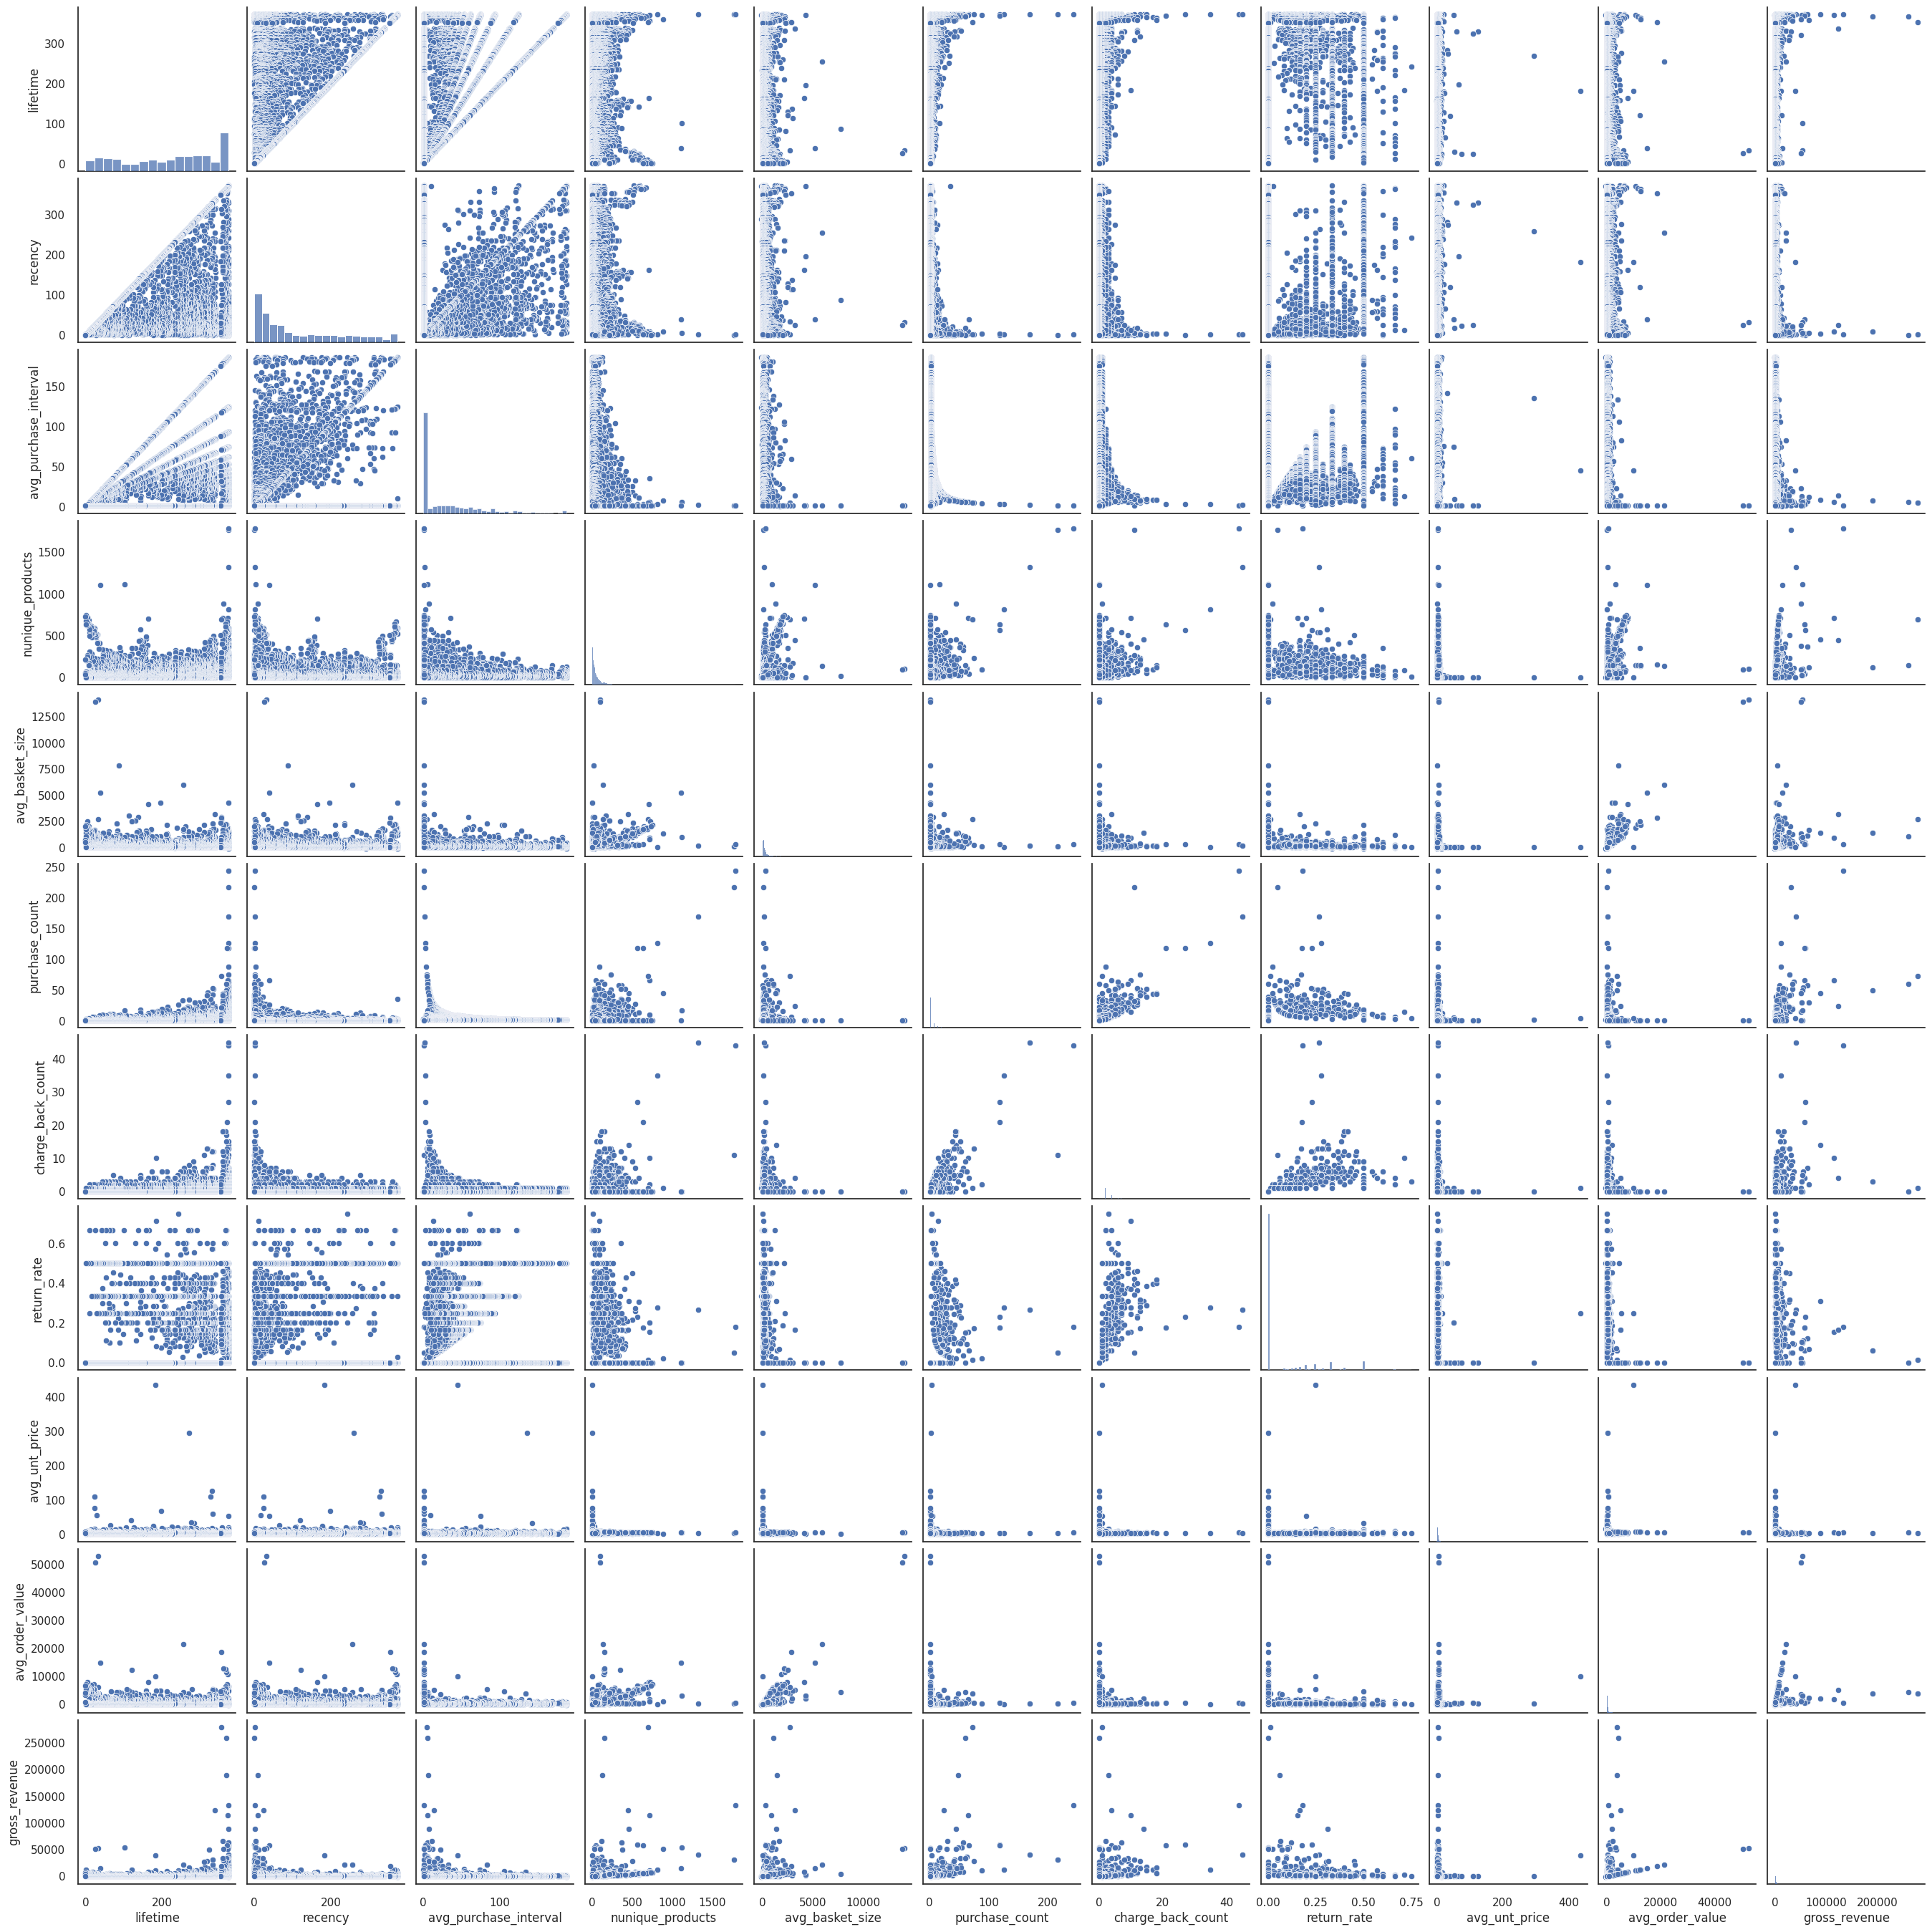

In [70]:
sns.pairplot(df5.drop(columns='customer_id'))

- avg_unit_price has low variance

# 6.0. Pre Processing

In [71]:
df6 = df5.copy()
X = df6.drop(columns = 'customer_id')
cols = X.columns

In [72]:
# instancing minmax
minmax = MinMaxScaler()

# transforming data
X = pd.DataFrame(minmax.fit_transform(X), columns=cols)

In [73]:
X.describe().T

count      mean       std  min       25%       50%       75%  max
lifetime               5706.0  0.579499  0.312523  0.0  0.292225  0.638070  0.852547  1.0
recency                5706.0  0.313419  0.299129  0.0  0.061662  0.190349  0.535523  1.0
avg_purchase_interval  5706.0  0.176086  0.238035  0.0  0.001794  0.062991  0.282191  1.0
nunique_products       5706.0  0.038441  0.056946  0.0  0.006723  0.019608  0.046499  1.0
avg_basket_size        5706.0  0.025577  0.029345  0.0  0.014410  0.019175  0.027818  1.0
purchase_count         5706.0  0.012626  0.033599  0.0  0.000000  0.004132  0.012397  1.0
charge_back_count      5706.0  0.013058  0.038868  0.0  0.000000  0.000000  0.022222  1.0
return_rate            5706.0  0.102541  0.197838  0.0  0.000000  0.000000  0.121212  1.0
avg_unt_price          5706.0  0.008408  0.018044  0.0  0.004964  0.006873  0.009641  1.0
avg_order_value        5706.0  0.017065  0.025390  0.0  0.010101  0.012123  0.015601  1.0
gross_revenue          5706.0  0.008998  0.026322  0.0  0.003674  0.005008  0.008375  1.0

In [74]:
clusters = np.arange(2,10,1)

## 7.1. Within-Cluster Sum of Squares (WSS)

The WSS (Within-Cluster-Sum-of-Squares) metric is a measure of clustering quality that is used to evaluate the goodness of fit of a clustering algorithm. The idea behind this metric is to calculate the sum of the squared distances between each point in a cluster and the center of that cluster, and then sum those values across all clusters. The resulting value gives us a measure of how tightly the points in a given cluster are clustered around its centroid.

The WSS metric is useful for comparing the quality of different clusterings of the same dataset. A lower WSS score indicates that the clusters are more tightly grouped around their respective centroids, which is generally considered to be a better clustering solution. However, it's important to note that the optimal number of clusters for a given dataset is not always clear-cut and may require some experimentation to find the best fit.

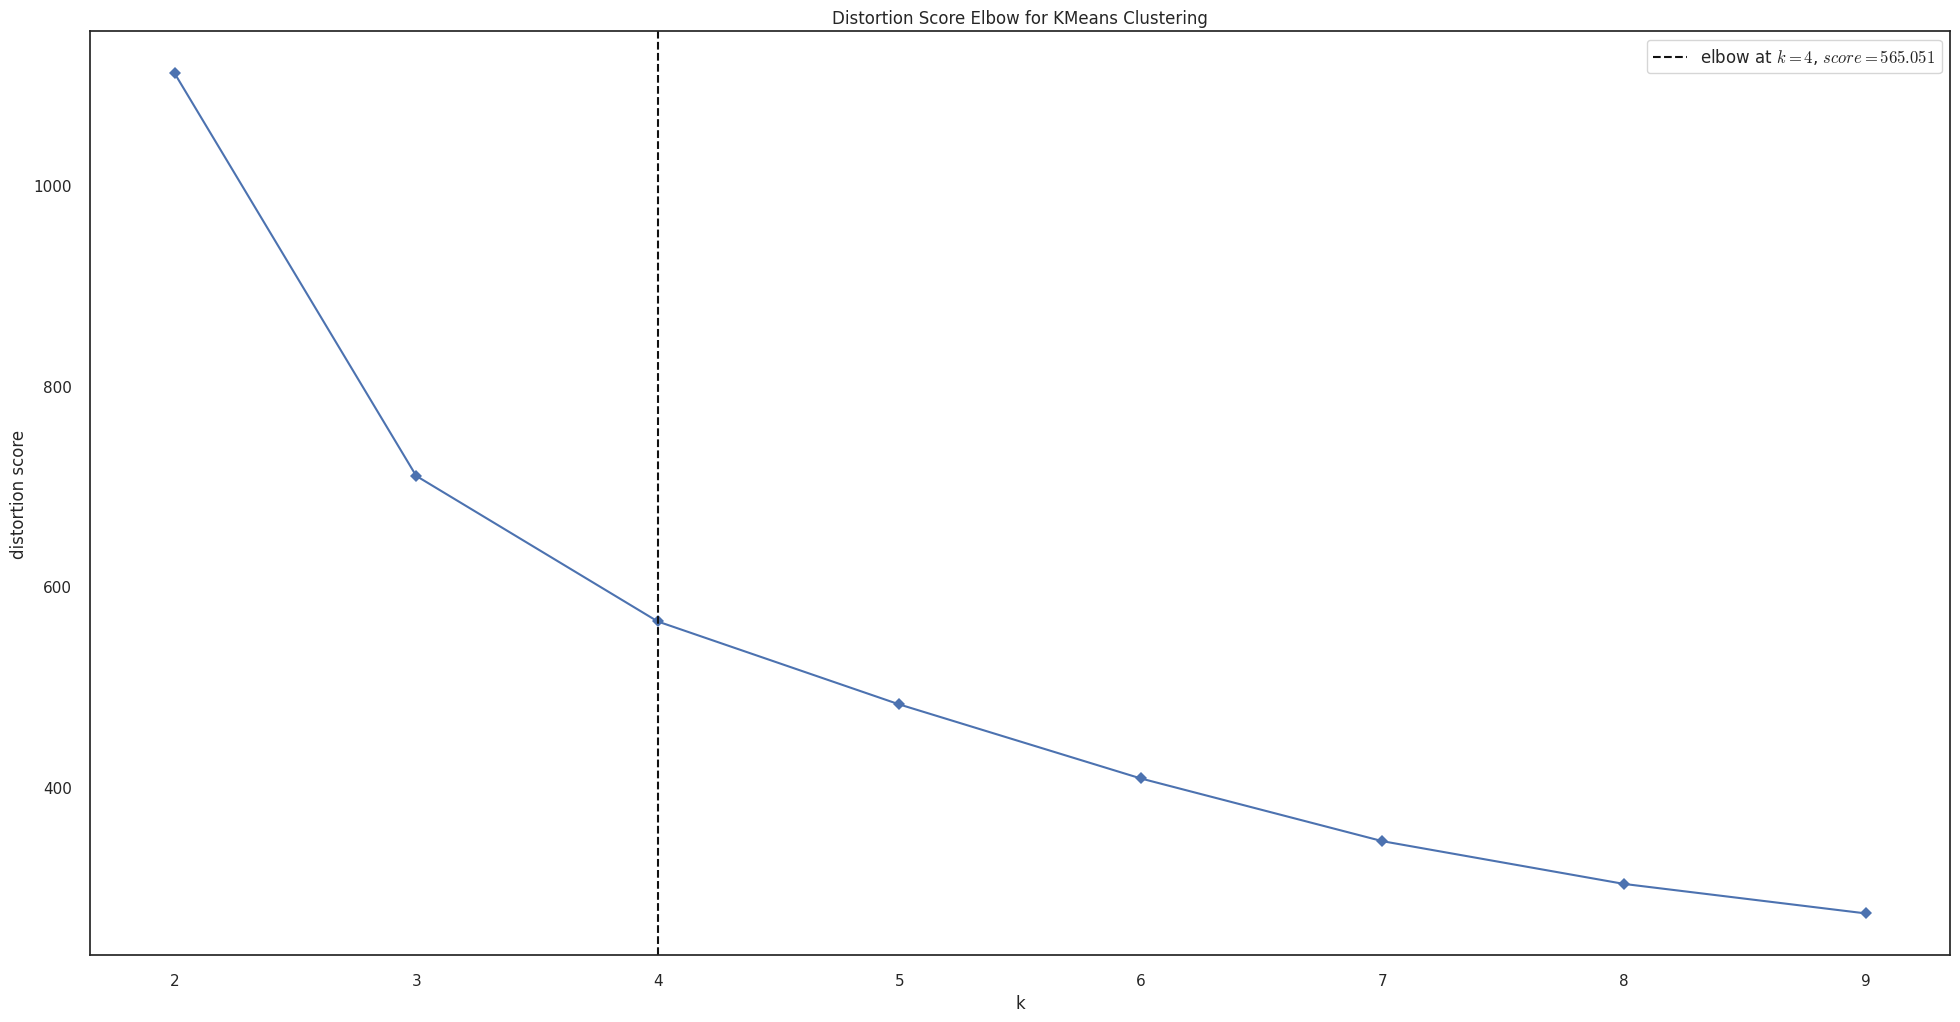

In [75]:
kmeans = KElbowVisualizer( KMeans(init='k-means++'), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2. Sihoutte Score

Silhouette score is a metric used to evaluate the performance of clustering algorithms. It measures how well each data point fits into its assigned cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a score of 1 indicates that the data point is well-matched to its own cluster and poorly-matched to neighboring clusters, and a score of -1 indicates the opposite. A score of 0 indicates that the data point is on the boundary between two clusters. A high silhouette score indicates that the clustering is appropriate, while a low score indicates that the data points may have been assigned to the wrong cluster. The silhouette score is often used to determine the optimal number of clusters for a given dataset.

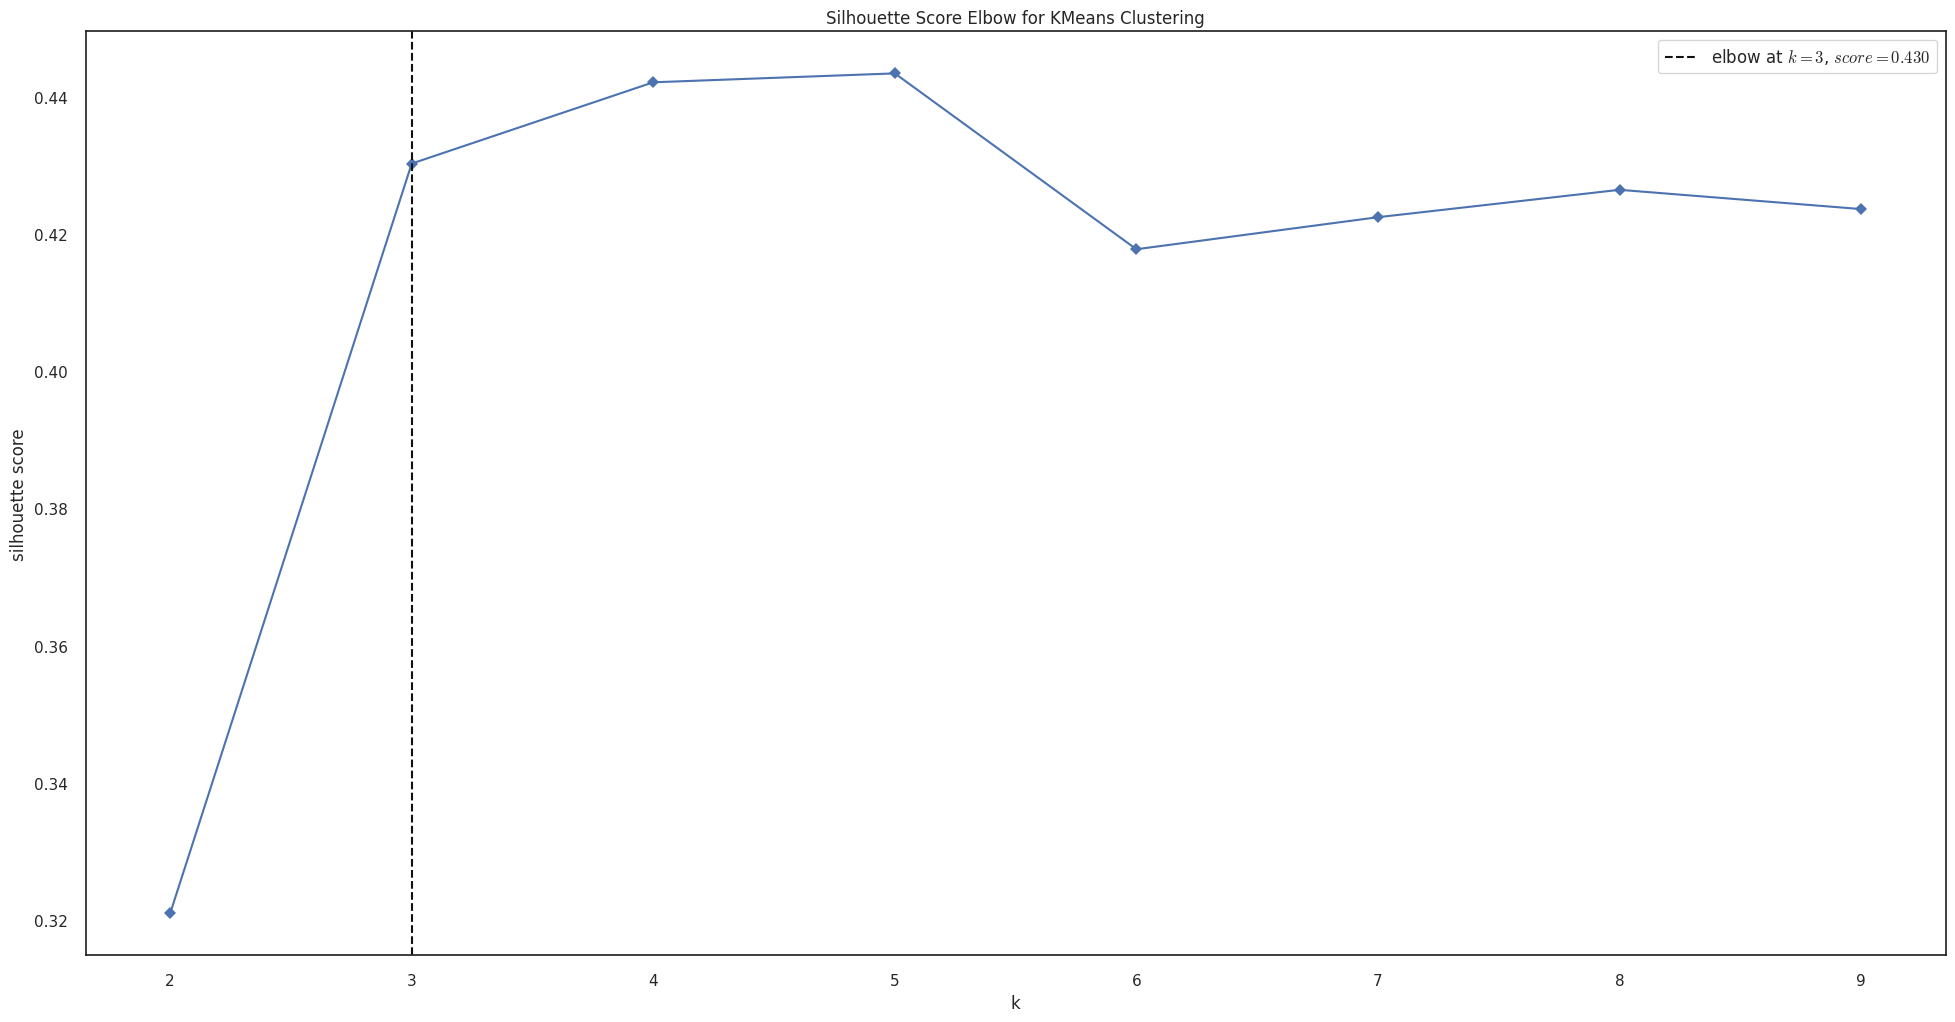

In [76]:
kmeans = KElbowVisualizer( KMeans(init='k-means++'), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

### 7.2.1. Silhouette Analysis

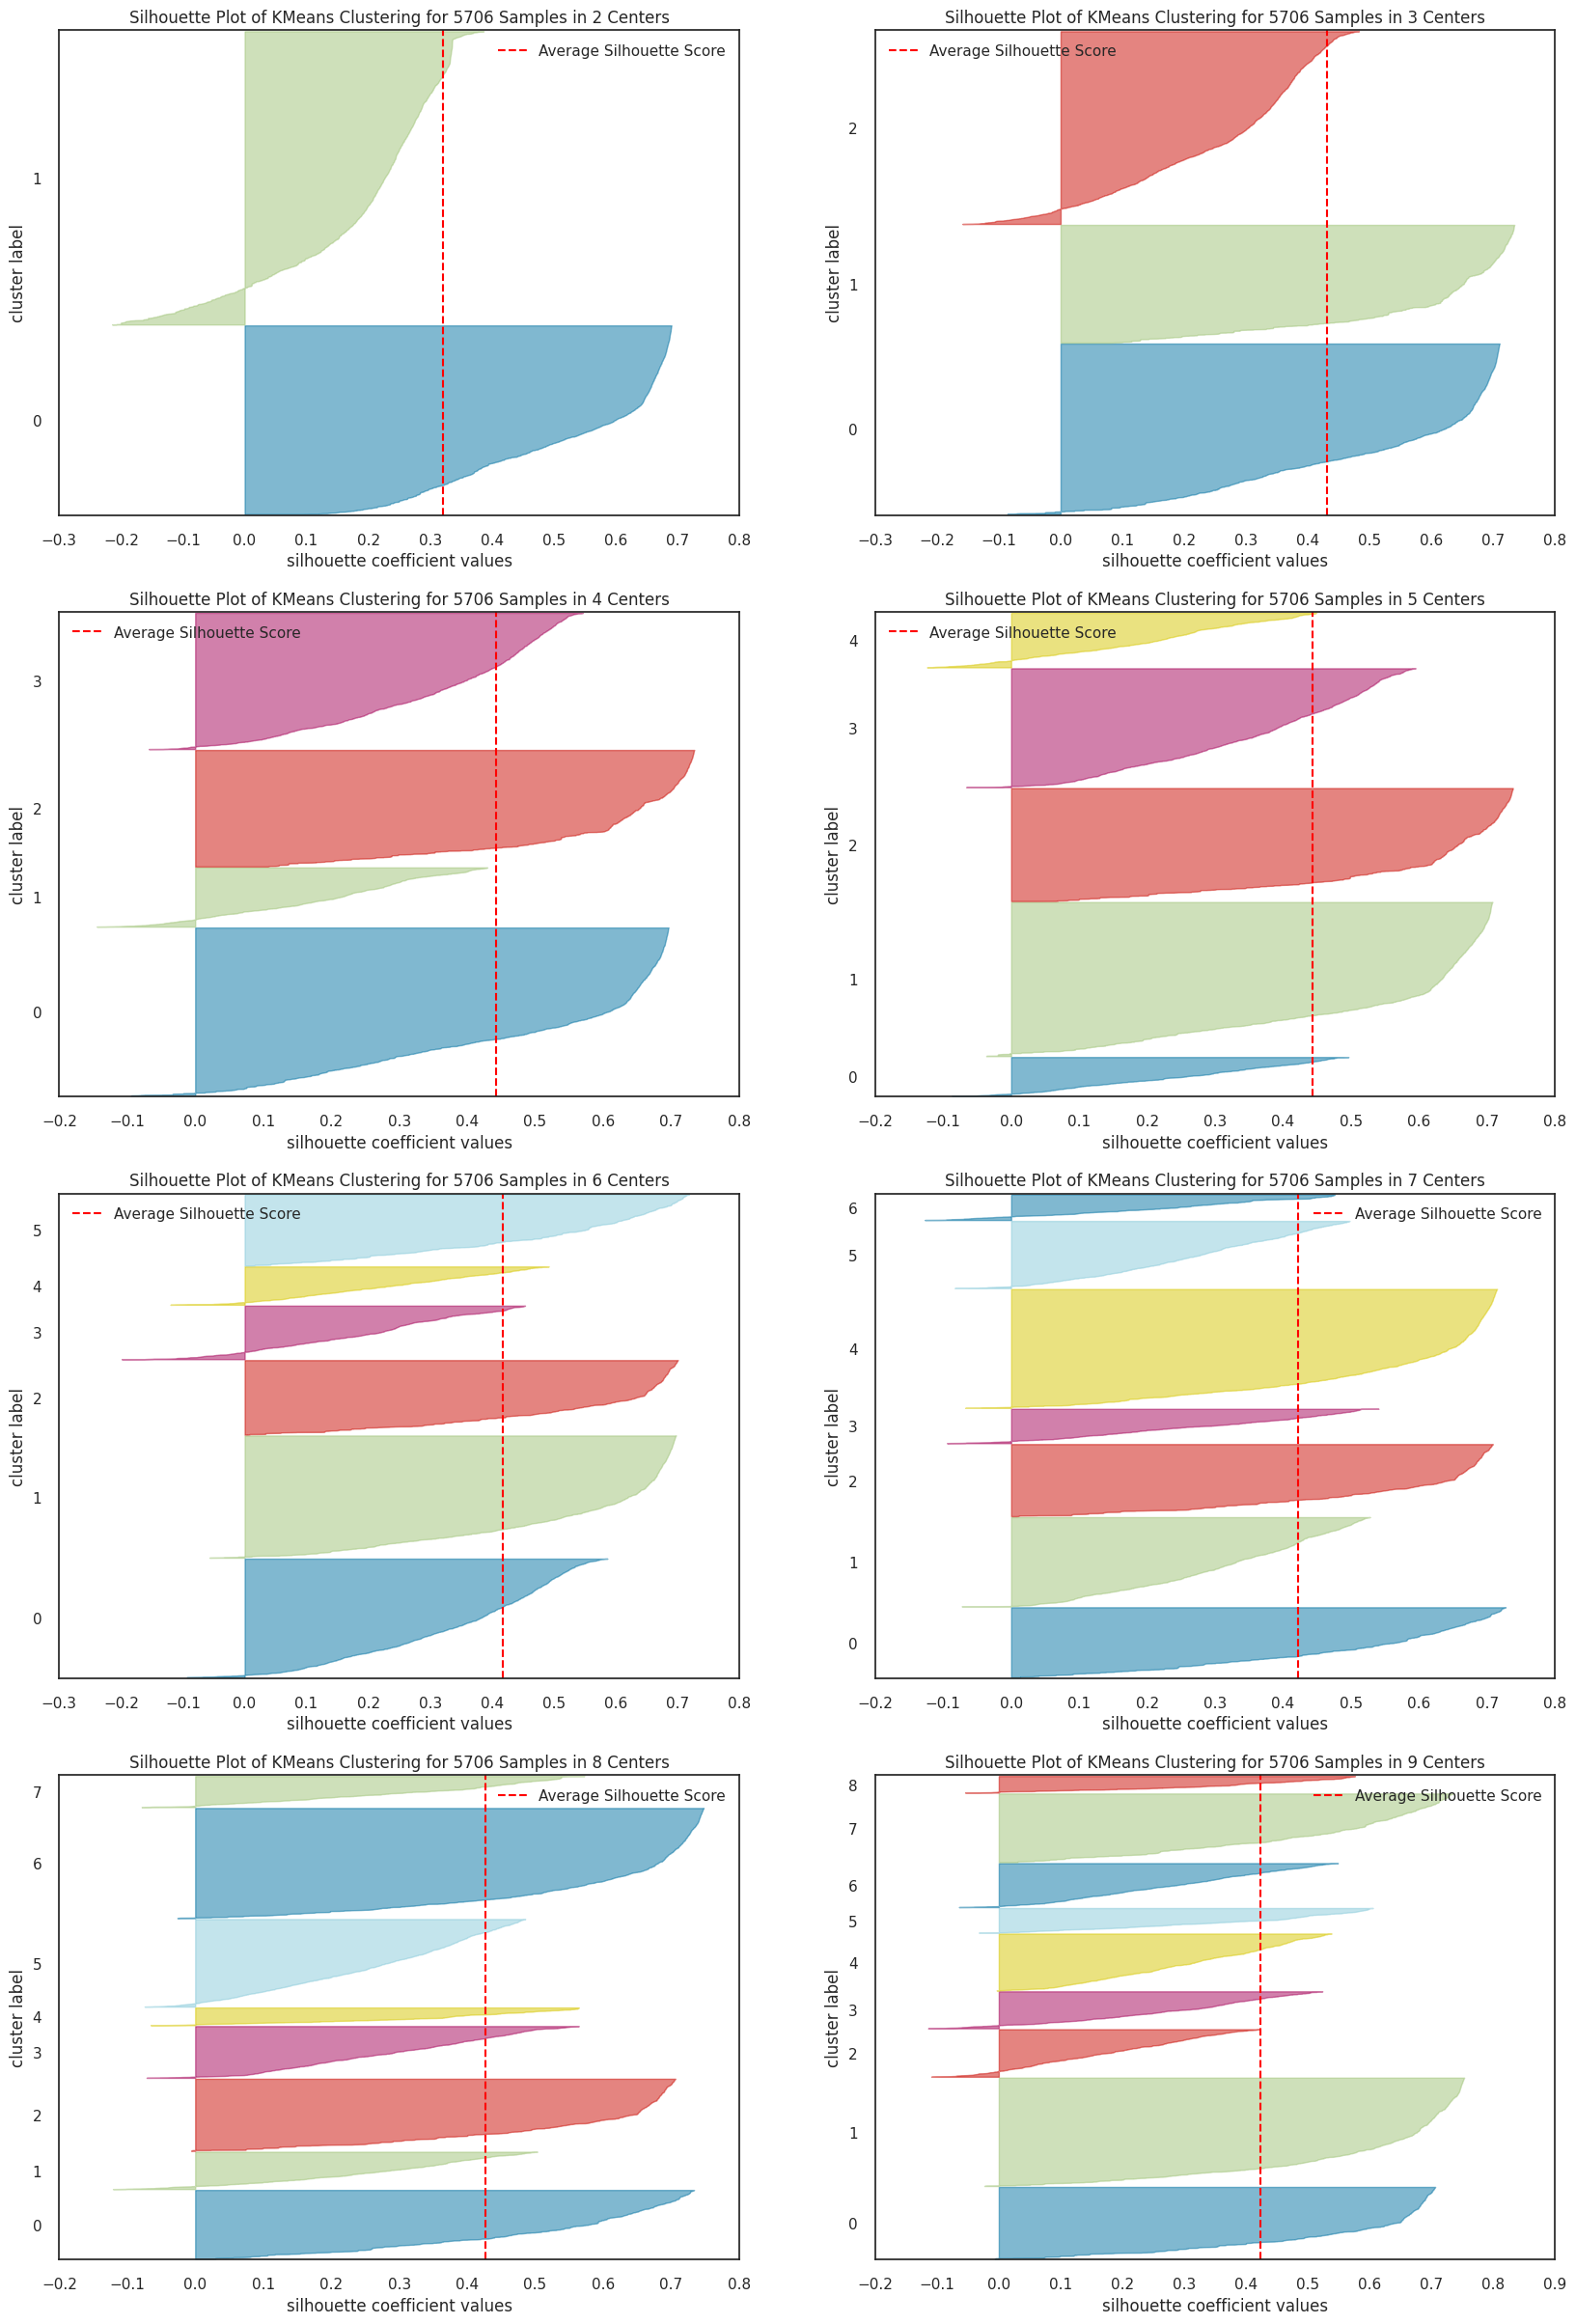

In [77]:
fig, ax = plt.subplots( 4, 2, figsize=(20, 30) )

for k in clusters:
    km = KMeans( n_clusters=k, init='k-means++', random_state=25 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0. Model Training

Although the WSS metric suggests that the best number of clusters is k=4 and the SS metric suggests k=5, it is important to note that having 5 clusters is not significantly worse than having 4. Therefore, I have decided to set the number of clusters to 5.

## 8.1. KMeans

In [78]:
# number of clusters
k = 5

# model definition
kmeans = KMeans( init='k-means++', n_clusters=k)

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_ 

## 8.2. KMeans Metrics

In [79]:
# WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# SS ( Silhouette Score )
print( 'SS value: {}'.format( metrics.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 482.3711216972797
SS value: 0.44341938755354493


# 9.0. Cluster Analysis 

In [80]:
df8 = df6.copy()
df8['cluster'] = labels
df8.head()

customer_id  lifetime  recency  avg_purchase_interval  nunique_products  avg_basket_size  purchase_count  charge_back_count  return_rate  avg_unt_price  avg_order_value  gross_revenue  cluster
0      17850.0     373.0    372.0              10.657143              21.0        48.371429              35                1.0     0.028571       3.960370       151.103714        5288.63        1
1      13047.0     373.0     56.0              23.312500             105.0        84.687500              16                7.0     0.437500       3.926082       193.068750        3089.10        2
2      12583.0     373.0      2.0              21.941176             114.0       292.823529              17                2.0     0.117647       2.140474       389.961176        6629.34        2
3      13748.0     373.0     95.0              74.600000              24.0        87.800000               5                0.0     0.000000       3.996429       189.650000         948.25        2
4      15100.0     373.0    333.0              62.166667               1.0         9.666667               6                3.0     0.500000      10.950000       105.850000         635.10        1

## 9.1. Visualization Inspection

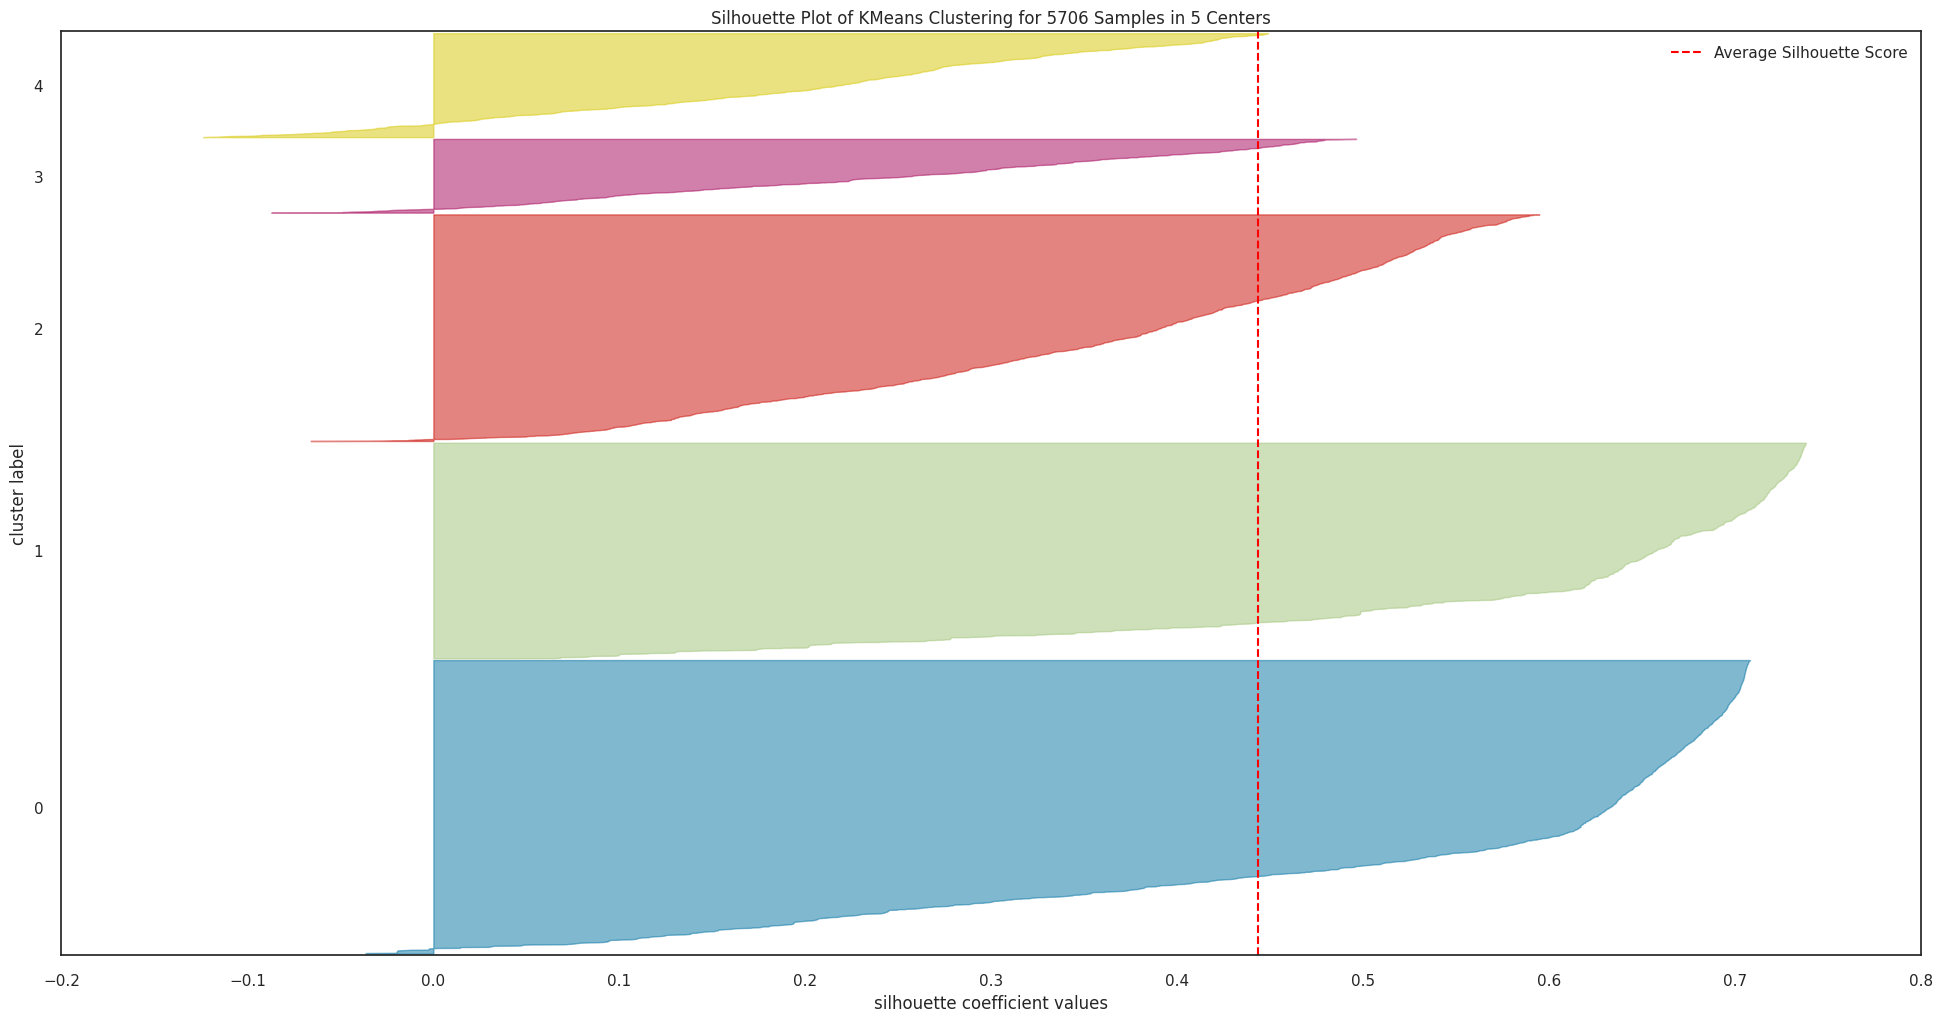

In [81]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize() 

## 9.2. 2d plot

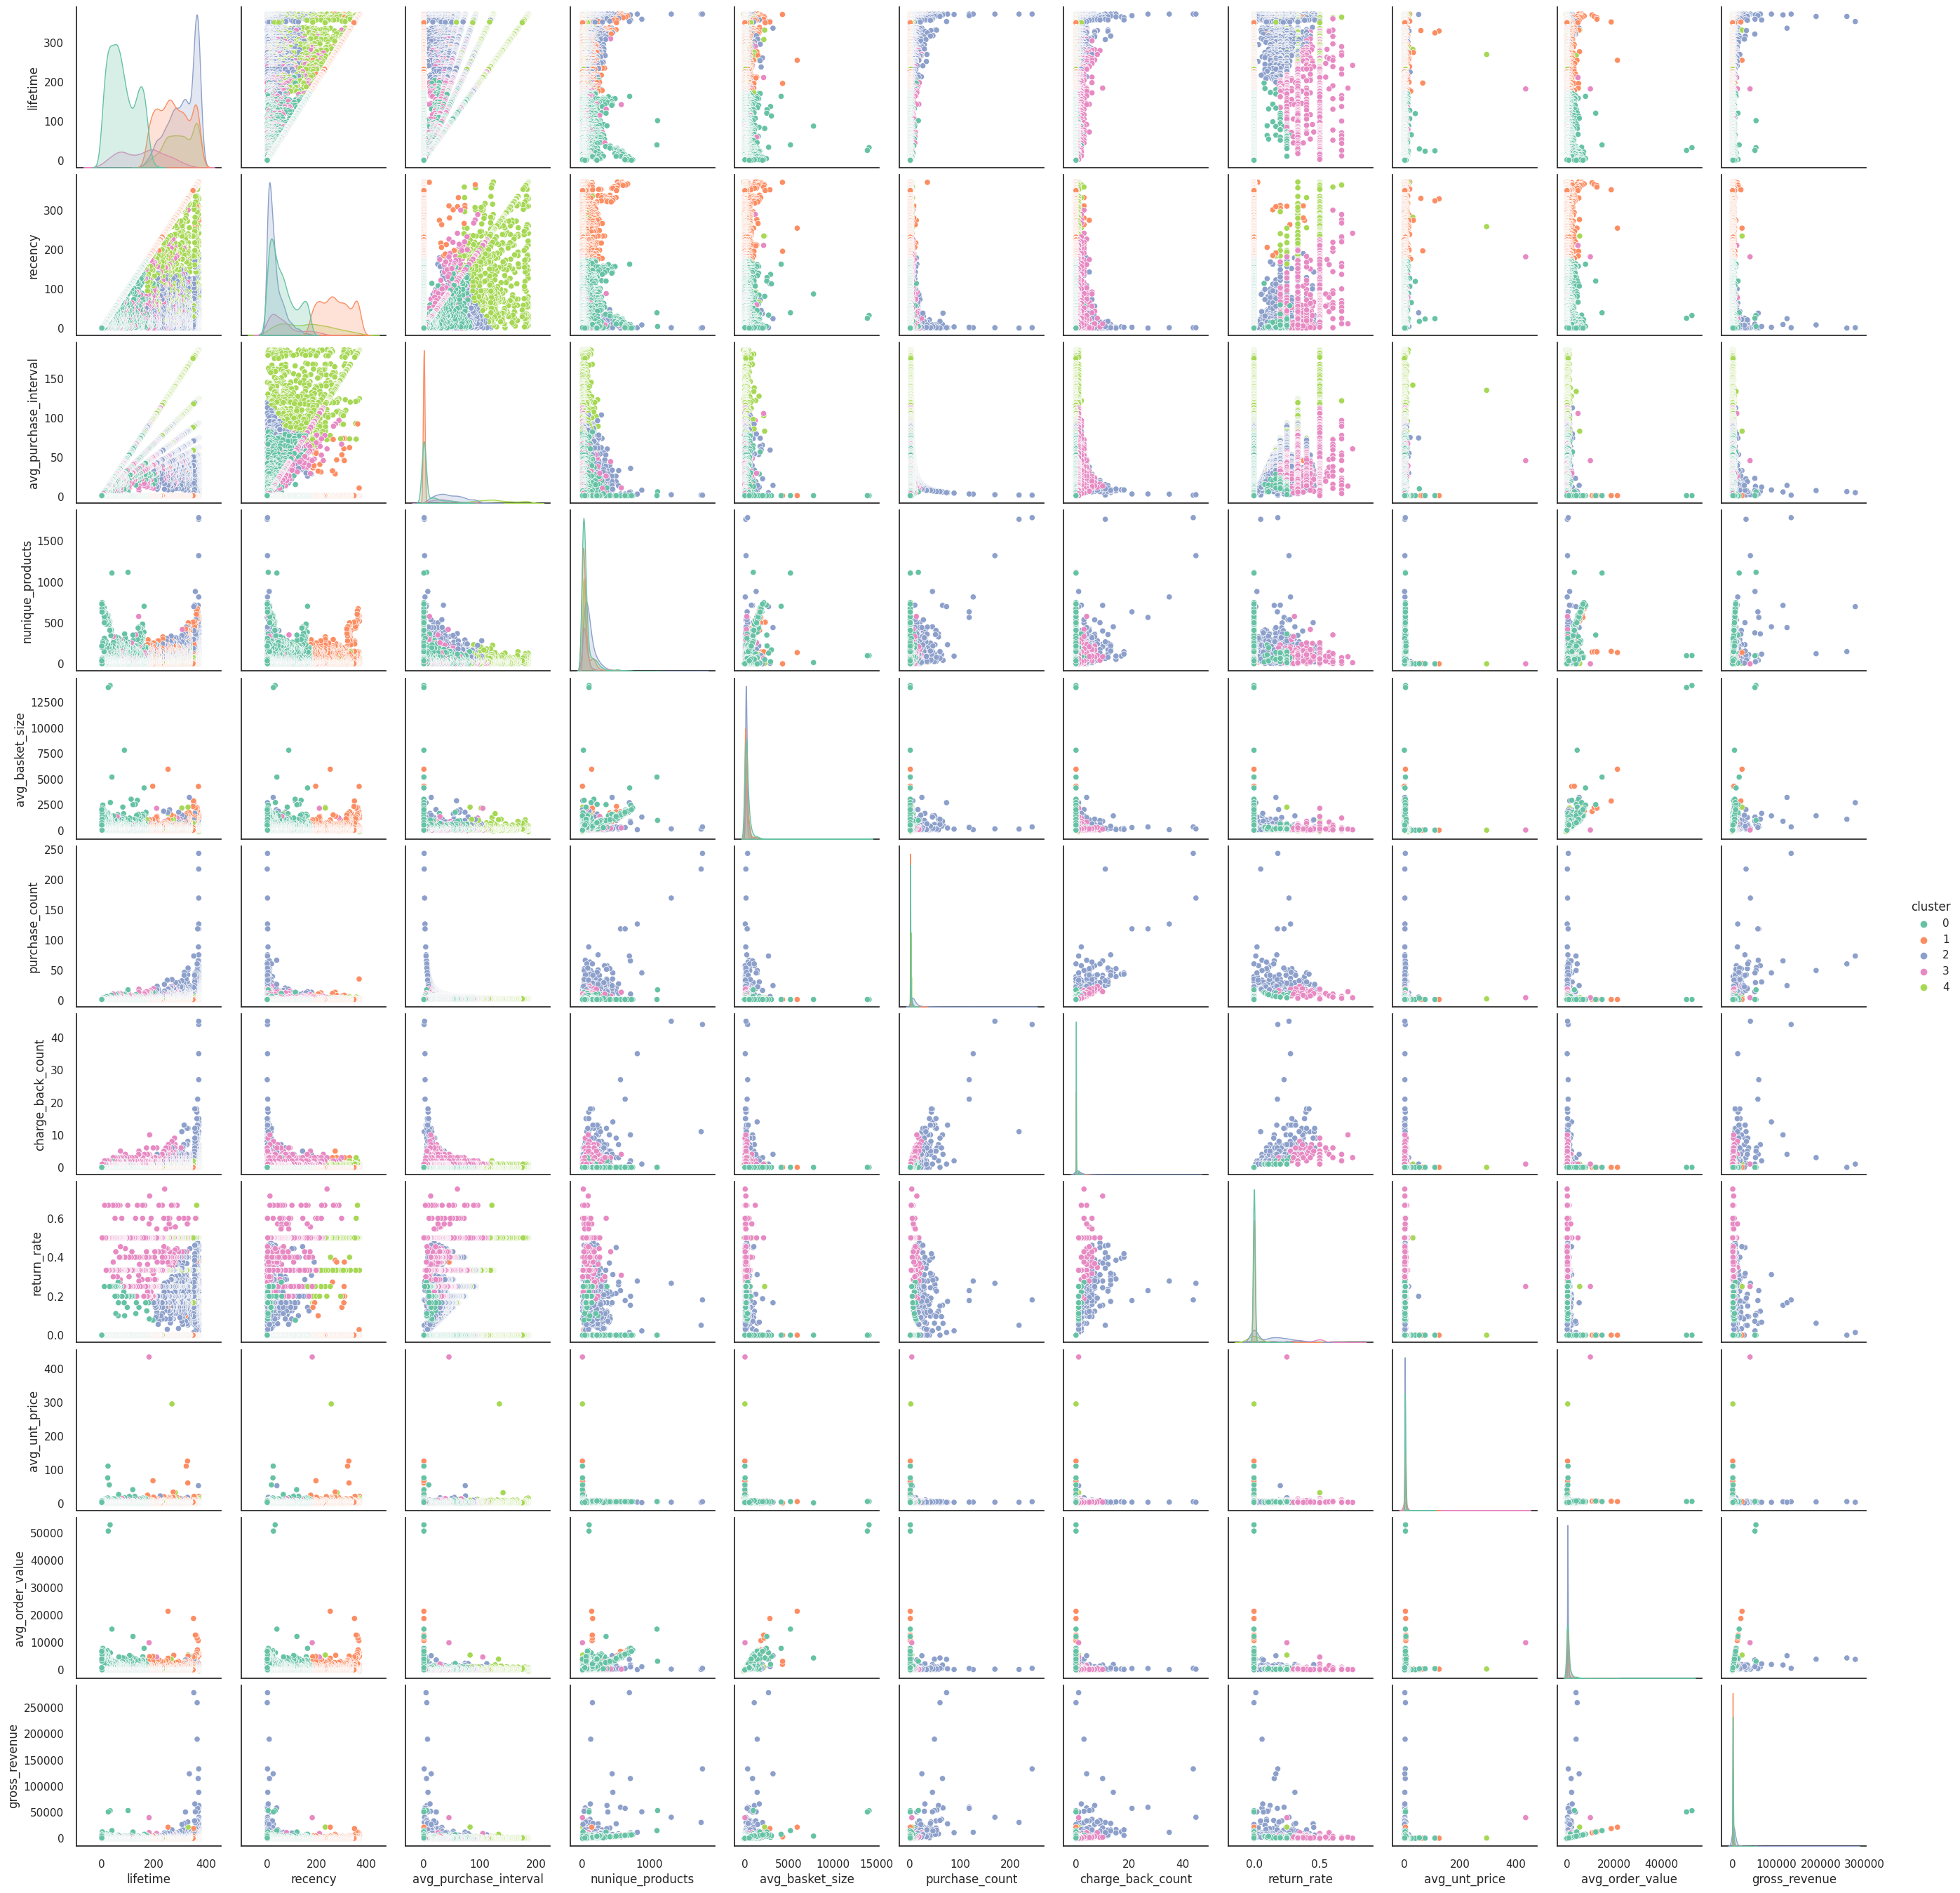

In [82]:
df_viz = df8.drop( columns='customer_id' )
sns.pairplot( df_viz, hue='cluster', palette='Set2' );

## 9.3. UMAP

**UMAP**

UMAP (Uniform Manifold Approximation and Projection) is a machine learning technique used for dimensionality reduction and visualization of high-dimensional data. It is similar to t-SNE, but it uses a different mathematical approach to preserve the global structure of the data. UMAP maps the high-dimensional data into a lower-dimensional space while maintaining the local and global structure of the data. This means that UMAP is useful for visualizing complex datasets in two or three dimensions, while preserving the relationships between the data points. UMAP has been successfully used in a variety of applications such as image and text analysis, genomics, and social network analysis.

**n_neighbours**

In UMAP, the n_neighbors parameter is used to control the balance between preserving the global structure of the data and capturing the local structure. It refers to the number of nearest neighbors that UMAP uses to construct a weighted graph of the input data.

A higher value of n_neighbors leads to more global structure being preserved, but may obscure more of the fine-grained, local structure. Conversely, a lower value of n_neighbors may lead to a more detailed representation of the local structure, but may fail to capture the larger-scale structure of the data.

**min_dist**

In UMAP, the min_dist parameter is used to control how tightly the algorithm should pack points together in the low-dimensional space. It refers to the minimum distance between points in the low-dimensional embedding.

A lower value of min_dist leads to more tightly packed clusters in the low-dimensional space, but may also cause points to be artificially pushed apart. Conversely, a higher value of min_dist allows for more separation between points, but may lead to more diffuse clusters.

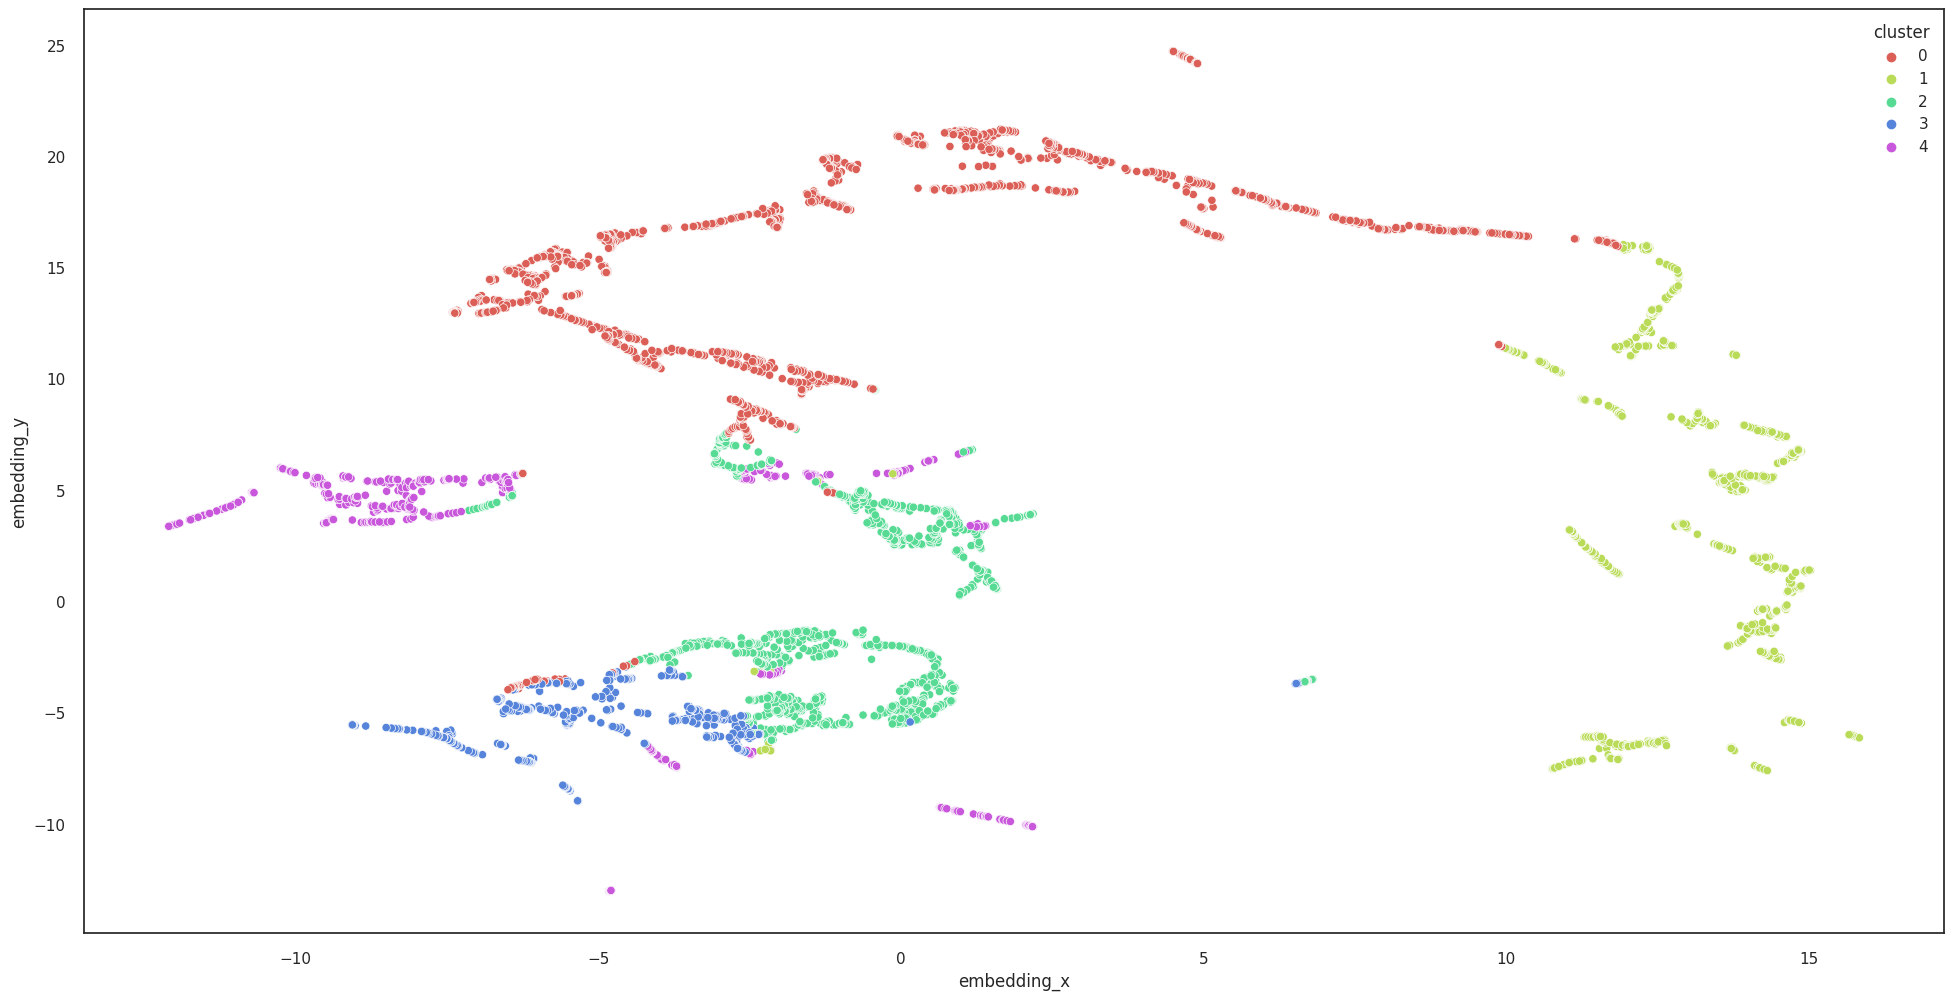

In [83]:
reducer = umap.UMAP( n_neighbors=10, random_state=0, min_dist=0.05)
embedding = reducer.fit_transform( X )

# embedding ( components )
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz );

After testing various values for the parameters in UMAP, I chose to use n_neighbors = 10, and min_dist=0.05. This means that UMAP will use the 10 nearest neighbors of each data point to construct a weighted graph and approximate the topology of the data in a 2D graph. By doing so, UMAP is able to preserve both local and global structures in the data.


## 9.4. Cluster Profile

In [84]:
clusters_info = (df8.groupby('cluster').agg({
                                             'cluster': lambda x: len(x),
                                             'customer_id': lambda x: np.round((len(x))/len(df8),3)})
                                             .rename(columns = {'cluster':'n_customer',
                                                                'customer_id':'perc_customer'}).reset_index())

customers_means = df8.drop(columns='customer_id').groupby('cluster').mean().reset_index()

clusters_info = clusters_info.merge(customers_means, how='left', on='cluster')

clusters_info

cluster  n_customer  perc_customer    lifetime     recency  avg_purchase_interval  nunique_products  avg_basket_size  purchase_count  charge_back_count  return_rate  avg_unt_price  avg_order_value  gross_revenue
0        0        1834          0.321   80.502181   63.162486               9.452457         63.251363       287.409169        1.619956           0.029989     0.005273       3.473604       693.972912     916.331636
1        1        1346          0.236  277.116642  276.040119               1.755182         54.861813       206.763013        1.117385           0.022288     0.002703       4.527813       629.436306     653.834591
2        2        1415          0.248  314.204240   31.224735              48.298685        110.588693       209.067826       10.561837           1.600707     0.124604       3.075346       344.023192    4391.756290
3        3         461          0.081  158.334056   67.802603              40.140727         54.967462       147.825535        4.629067           1.845987     0.413266       4.204223       268.946700    1221.879414
4        4         650          0.114  300.212308  160.356923             129.189949         39.335385       175.974000        2.440000           0.233846     0.090282       3.749173       291.796245     722.250062

In [85]:
for cluster in clusters_info.cluster:
    for col in clusters_info.columns:
        value = (clusters_info.loc[clusters_info.cluster == cluster, col].values[0])
        print(col + ': ' + str(value.round(2)))
    print('\n')

cluster: 0
n_customer: 1834
perc_customer: 0.32
lifetime: 80.5
recency: 63.16
avg_purchase_interval: 9.45
nunique_products: 63.25
avg_basket_size: 287.41
purchase_count: 1.62
charge_back_count: 0.03
return_rate: 0.01
avg_unt_price: 3.47
avg_order_value: 693.97
gross_revenue: 916.33


cluster: 1
n_customer: 1346
perc_customer: 0.24
lifetime: 277.12
recency: 276.04
avg_purchase_interval: 1.76
nunique_products: 54.86
avg_basket_size: 206.76
purchase_count: 1.12
charge_back_count: 0.02
return_rate: 0.0
avg_unt_price: 4.53
avg_order_value: 629.44
gross_revenue: 653.83


cluster: 2
n_customer: 1415
perc_customer: 0.25
lifetime: 314.2
recency: 31.22
avg_purchase_interval: 48.3
nunique_products: 110.59
avg_basket_size: 209.07
purchase_count: 10.56
charge_back_count: 1.6
return_rate: 0.12
avg_unt_price: 3.08
avg_order_value: 344.02
gross_revenue: 4391.76


cluster: 3
n_customer: 461
perc_customer: 0.08
lifetime: 158.33
recency: 67.8
avg_purchase_interval: 40.14
nunique_products: 54.97
avg_baske